In [14]:
!pip install statsforecast --quiet

In [15]:
import sklearn
print(sklearn.__version__)


1.7.1


In [17]:
!pip install "u8darts[all]" --quiet


In [18]:
import sys
sys.path.append("/kaggle/input/lib-power-prediction")
from tqdm.auto import tqdm
from lib.model_utils import preprocess_features, train_and_evaluate_model, plot_forecast, forecast_bias
from lib.utils import compact_to_expanded, imputation, format_plot
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import plotly.express as px
from pathlib import Path
from darts.timeseries import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, TFTModel, NBEATSModel, TSMixerModel
import torch

In [ ]:
lclid_acorn_map = pd.read_pickle("/kaggle/input/data-output-power-prediction/london_smart_meters_lclid_acorn_map.pkl")

In [ ]:
print(lclid_acorn_map.columns)

In [ ]:
print(lclid_acorn_map['Acorn_grouped'].unique())

In [ ]:
affluent_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="Affluent", ["LCLid",'file']]
acorn_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="ACORN-", ["LCLid",'file']]
adversity_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="Adversity", ["LCLid",'file']]
acornu_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="ACORN-U", ["LCLid",'file']]
comfortable_households = lclid_acorn_map.loc[lclid_acorn_map.Acorn_grouped=="Comfortable", ["LCLid",'file']]

In [ ]:
print(len(acorn_households))
print(len(acornu_households))

In [ ]:
selected_households = pd.concat(
    [
        affluent_households.sample(50, random_state=76),
        comfortable_households.sample(50, random_state=76),
        adversity_households.sample(50, random_state=76),
        acorn_households.sample(len(acorn_households), random_state=76),
        acornu_households.sample(len(acornu_households), random_state=76),
    ]
)
selected_households['block']=selected_households.file.str.split("_", expand=True).iloc[:,1].astype(int)

In [ ]:
selected_households

In [ ]:
from pathlib import Path

# thư mục chứa dữ liệu
data_dir = Path("/kaggle/input/data-output-power-prediction")

# extracting the paths to the different blocks and extracting the starting and ending blocks
path_blocks = [
    (p, *list(map(int, p.name.split("_")[5].split(".")[0].split("-"))))
    for p in data_dir.glob(
        "london_smart_meters_merged_block*"
    )
]


In [ ]:
household_df_l = []
for path, start_b, end_b in tqdm(path_blocks):
    block_df = pd.read_parquet(path)
    selected_households['block'].between
    mask = selected_households['block'].between(start_b, end_b)
    lclids = selected_households.loc[mask, "LCLid"]
    household_df_l.append(block_df.loc[block_df.LCLid.isin(lclids)])

In [ ]:
block_df = pd.concat(household_df_l)
del household_df_l
block_df.head()

In [ ]:
# Lọc dữ liệu theo LCLid = "MAC003069"
mac_df = block_df[block_df["LCLid"] == "MAC003069"]
mac_df.head()

In [ ]:
block_df.info()

In [ ]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df, timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

In [ ]:
exp_block_df.info()

In [ ]:
test_mask = (exp_block_df.timestamp.dt.year==2014) & (exp_block_df.timestamp.dt.month==2)
val_mask = (exp_block_df.timestamp.dt.year==2014) & (exp_block_df.timestamp.dt.month==1)

train = exp_block_df[~(val_mask|test_mask)]
val = exp_block_df[val_mask]
test = exp_block_df[test_mask]
print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}")
print(f"Max Date in Train: {train.timestamp.max()} | Min Date in Validation: {val.timestamp.min()} | Min Date in Test: {test.timestamp.min()}")

In [ ]:
train.head()

In [ ]:
train.to_parquet("/kaggle/working/selected_blocks_train.parquet")
val.to_parquet("/kaggle/working/selected_blocks_val.parquet")
test.to_parquet("/kaggle/working/selected_blocks_test.parquet")

Filling in missing values

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

In [ ]:
val.isnull().sum()

In [ ]:
ts_train = train.set_index("timestamp")
train_imputed = imputation(ts_train)
train_imputed = train_imputed.drop('energy_consumption', axis=1)

ts_val = val.set_index("timestamp")
val_imputed = imputation(ts_val)
val_imputed = val_imputed.drop('energy_consumption', axis=1)

ts_test = test.set_index("timestamp")
test_imputed = imputation(ts_test)
test_imputed = test_imputed.drop('energy_consumption', axis=1)

In [ ]:
train_imputed = train_imputed.reset_index()
val_imputed = val_imputed.reset_index()
test_imputed = test_imputed.reset_index()

In [ ]:
train_imputed.to_parquet("/kaggle/working/selected_blocks_train_missing_imputed.parquet")
val_imputed.to_parquet("/kaggle/working/selected_blocks_val_missing_imputed.parquet")
test_imputed.to_parquet("/kaggle/working/selected_blocks_test_missing_imputed.parquet")

In [ ]:
!pip install window-ops

In [ ]:
from lib.feature_engineering_utils import add_lags, LogTime, add_temporal_features
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
np.random.seed(42)
tqdm.pandas()

In [ ]:
train_df = pd.read_parquet("/kaggle/input/data-power/selected_blocks_train_missing_imputed.parquet")
val_df = pd.read_parquet("/kaggle/input/data-power/selected_blocks_val_missing_imputed.parquet")
test_df = pd.read_parquet("/kaggle/input/data-power/selected_blocks_test_missing_imputed.parquet")

In [ ]:
train_df["type"] = "train"
val_df["type"] = "val"
test_df["type"] = "test"
full_df = pd.concat([train_df, val_df, test_df]).sort_values(["LCLid", "timestamp"])
del train_df, test_df, val_df

In [ ]:
full_df.columns

In [ ]:
full_df = full_df.rename(columns={'energy_consumption_imputed': 'energy_consumption'})

In [ ]:
lags = (
    (np.arange(5) + 1).tolist()
    + (np.arange(5) + 46).tolist()
    + (np.arange(5) + (48 * 7) - 2).tolist()
)
lags

In [ ]:
with LogTime():
    full_df, added_features = add_lags(
        full_df, lags=lags, column="energy_consumption", ts_id="LCLid", use_32_bit=True
    )
print(f"Features Created: {','.join(added_features)}")

In [ ]:
with LogTime():
    full_df, added_features = add_temporal_features(
        full_df,
        field_name="timestamp",
        frequency="30min",
        add_elapsed=True,
        drop=False,
        use_32_bit=True,
    )
print(f"Features Created: {','.join(added_features)}")

In [ ]:
full_df

In [ ]:
full_df.columns

In [ ]:
full_df[full_df["type"] == "train"].drop(columns="type").to_parquet(
    "/kaggle/working/selected_blocks_train_missing_imputed_feature_engg.parquet"
)
full_df[full_df["type"] == "val"].drop(columns="type").to_parquet(
    "/kaggle/working/selected_blocks_val_missing_imputed_feature_engg.parquet"
)
full_df[full_df["type"] == "test"].drop(columns="type").to_parquet(
    "/kaggle/working/selected_blocks_test_missing_imputed_feature_engg.parquet"
)

In [19]:
train_df = pd.read_parquet("/kaggle/input/data-power/selected_blocks_train_missing_imputed_feature_engg.parquet")
val_df = pd.read_parquet("/kaggle/input/data-power/selected_blocks_val_missing_imputed_feature_engg.parquet")
test_df = pd.read_parquet("/kaggle/input/data-power/selected_blocks_test_missing_imputed_feature_engg.parquet")

In [20]:
import pandas as pd
train_df = pd.concat([train_df, val_df])
del val_df

In [21]:
train_df

,timestamp,LCLid,frequency,timestamp_Week,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Is_quarter_start,timestamp_Is_year_end,timestamp_Is_year_start,timestamp_Is_month_start,timestamp_Day,timestamp_Dayofweek,timestamp_Dayofyear,timestamp_Hour,timestamp_Minute,timestamp_Elapsed
3619152,2012-01-01 00:00:00,MAC000061,30min,52,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,1,0,1,1,1,6,1,0,0,1325376000
3619153,2012-01-01 00:30:00,MAC000061,30min,52,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,1,0,1,1,1,6,1,0,30,1325377800
3619154,2012-01-01 01:00:00,MAC000061,30min,52,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,1,0,1,1,1,6,1,1,0,1325379600
3619155,2012-01-01 01:30:00,MAC000061,30min,52,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,1,0,1,1,1,6,1,1,30,1325381400
3619156,2012-01-01 02:00:00,MAC000061,30min,52,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,1,0,1,1,1,6,1,2,0,1325383200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221707,2014-01-31 21:30:00,MAC005529,30min,5,32688,ToU,ACORN-L,Adversity,block_82,NO_HOLIDAY,...,0,0,0,0,31,4,31,21,30,1391203800
221708,2014-01-31 22:00:00,MAC005529,30min,5,32688,ToU,ACORN-L,Adversity,block_82,NO_HOLIDAY,...,0,0,0,0,31,4,31,22,0,1391205600
221709,2014-01-31 22:30:00,MAC005529,30min,5,32688,ToU,ACORN-L,Adversity,block_82,NO_HOLIDAY,...,0,0,0,0,31,4,31,22,30,1391207400
221710,2014-01-31 23:00:00,MAC005529,30min,5,32688,ToU,ACORN-L,Adversity,block_82,NO_HOLIDAY,...,0,0,0,0,31,4,31,23,0,1391209200


In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5518656 entries, 3619152 to 221711
Data columns (total 53 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   timestamp                   datetime64[ns]
 1   LCLid                       object        
 2   frequency                   object        
 3   timestamp_Week              int32         
 4   series_length               int64         
 5   stdorToU                    object        
 6   Acorn                       object        
 7   Acorn_grouped               object        
 8   file                        object        
 9   holidays                    object        
 10  visibility                  float64       
 11  windBearing                 int64         
 12  temperature                 float64       
 13  dewPoint                    float64       
 14  pressure                    float64       
 15  apparentTemperature         float64       
 16  windSpeed         

In [23]:
target=["energy_consumption"]
continuous_features=[
    "visibility",
    "windBearing",
    "temperature",
    "dewPoint",
    "pressure",
    "apparentTemperature",
    "windSpeed",
    "humidity",
    "energy_consumption_lag_1",
    "energy_consumption_lag_2",
    "energy_consumption_lag_3",
    "energy_consumption_lag_4",
    "energy_consumption_lag_5",
    "energy_consumption_lag_46",
    "energy_consumption_lag_47",
    "energy_consumption_lag_48",
    "energy_consumption_lag_49",
    "energy_consumption_lag_50",
    "energy_consumption_lag_334",
    "energy_consumption_lag_335",
    "energy_consumption_lag_336",
    "energy_consumption_lag_337",
    "energy_consumption_lag_338",
    "timestamp_Elapsed",
    "day_hourly_profile",
]
categorical_features=[
    "stdorToU",
    "Acorn",
    "Acorn_grouped",
    "holidays",
    "precipType",
    "icon",
    "summary",
    "timestamp_Month",
    "timestamp_Quarter",
    "timestamp_Week",
    "timestamp_Day",
    "timestamp_Dayofweek",
    "timestamp_Dayofyear",
    "timestamp_Hour",
    "timestamp_Minute",
    "weekday",
    "hour",
]
boolean_features=[
    "timestamp_Is_quarter_end",
    "timestamp_Is_quarter_start",
    "timestamp_Is_year_end",
    "timestamp_Is_year_start",
    "timestamp_Is_month_start",
]

In [24]:
train_df_ts = train_df.copy()
train_df_ts["timestamp"] = pd.to_datetime(train_df_ts["timestamp"], yearfirst=True)
train_df_ts = train_df_ts.set_index(['timestamp', 'LCLid'])
lcl_ids = sorted(train_df.LCLid.unique())
for lcl_id in lcl_ids:
    lcl_id_data = train_df_ts.xs(lcl_id, level='LCLid')
    lcl_id_data = lcl_id_data.asfreq('30min')
train_df_ts = train_df_ts.drop(['frequency', 'file'], axis=1)

In [25]:
bfill_columns=[
    "pressure",
    "energy_consumption_lag_1",
    "energy_consumption_lag_2",
    "energy_consumption_lag_3",
    "energy_consumption_lag_4",
    "energy_consumption_lag_5",
    "energy_consumption_lag_46",
    "energy_consumption_lag_47",
    "energy_consumption_lag_48",
    "energy_consumption_lag_49",
    "energy_consumption_lag_50",
    "energy_consumption_lag_334",
    "energy_consumption_lag_335",
    "energy_consumption_lag_336",
    "energy_consumption_lag_337",
    "energy_consumption_lag_338",
]
n_hashed_features = 32
hashed_features_list_train = []

In [26]:
processed_train = preprocess_features(train_df_ts, continuous_features, categorical_features, boolean_features,
                                      n_hashed_features, hashed_features_list_train, bfill_columns)

Handling missing values...


/kaggle/input/lib-power-prediction/lib/model_utils.py:651: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[bfill_cols] = df[bfill_cols].fillna(method="bfill")


Encoding categorical features...
Normalizing features...


In [27]:
test_df_ts = test_df.copy()
test_df_ts["timestamp"] = pd.to_datetime(test_df_ts["timestamp"], yearfirst=True)
test_df_ts = test_df_ts.set_index(['timestamp', 'LCLid'])
lcl_ids = sorted(test_df.LCLid.unique())
for lcl_id in lcl_ids:
    lcl_id_data = test_df_ts.xs(lcl_id, level='LCLid')
    lcl_id_data = lcl_id_data.asfreq('30min')
test_df_ts = test_df_ts.drop(['frequency', 'file'], axis=1)

In [28]:
hashed_features_list_test = []
processed_test = preprocess_features(test_df_ts, continuous_features, categorical_features, boolean_features,
                                      n_hashed_features, hashed_features_list_test, bfill_columns)

Handling missing values...
Encoding categorical features...


/kaggle/input/lib-power-prediction/lib/model_utils.py:651: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[bfill_cols] = df[bfill_cols].fillna(method="bfill")


Normalizing features...


In [29]:
# Model configurations
lstm_config = {
    'name': 'LSTM',
    'class': RNNModel,
    'params': {
        'model': "LSTM",
        'input_chunk_length': 96,   
        'output_chunk_length': 48,
        'training_length': 144,
        'hidden_dim': 16,           
        'n_rnn_layers': 1,         
        'dropout': 0.0,             
        'batch_size': 32,
        'n_epochs': 2,
        'optimizer_kwargs': {'lr': 0.001},
        'pl_trainer_kwargs': {
            'accelerator': "gpu" if torch.cuda.is_available() else "cpu",
            'devices': 1
        }
    }
}

nbeats_config = {
    'name': 'N-BEATS',
    'class': NBEATSModel,
    'params': {
        'input_chunk_length': 96,
        'output_chunk_length': 48,
        'generic_architecture': True,
        'num_stacks': 2,
        'num_blocks': 2,
        'num_layers': 2,
        'layer_widths': 64,
        'n_epochs': 2,
        'batch_size': 32,
        'pl_trainer_kwargs': {
            'accelerator': "gpu" if torch.cuda.is_available() else "cpu",
            'devices': 1
        }
    }
}
tsmixer_config = {
    'name': 'TSMixer',
    'class': TSMixerModel,
    'params': {
        'input_chunk_length': 96,
        'output_chunk_length': 48,
        'hidden_size': 64,
        'ff_size': 64,
        'num_blocks': 2,
        'activation': 'ReLU',
        'dropout': 0.2,
        'norm_type': 'LayerNorm',
        'normalize_before': False,
        'use_static_covariates': True,
        'n_epochs': 2,
        'batch_size': 32,
        'pl_trainer_kwargs': {
            'accelerator': "gpu" if torch.cuda.is_available() else "cpu",
            'devices': 1
        }
    }
}

In [30]:
# 1. Get unique household IDs
household_ids = processed_train.index.get_level_values('LCLid').unique()
print(f"Training on {len(household_ids)} households")
# 2. Initialize Scalers
target_scaler = Scaler()
covariates_scaler = Scaler()
# 3. Create empty lists to store series
train_series_list = []
train_covariates_list = []
test_series_list = []
test_covariates_list = []
all_predictions = []
all_metrics = []
WORKING_DIR = Path("/kaggle/working")

output_predictions_tsmixer = WORKING_DIR / "tsmixer_test_predictions.parquet"
output_metrics_tsmixer = WORKING_DIR / "tsmixer_test_metrics.parquet"

output_predictions_lstm = WORKING_DIR / "lstm_test_predictions.parquet"
output_metrics_lstm = WORKING_DIR / "lstm_test_metrics.parquet"

Training on 185 households


In [31]:
# 4. Process each household
for i, household_id in enumerate(household_ids[:50]):

    try:
        # Extract household data
        train_household = processed_train.xs(household_id, level="LCLid")
        test_household = processed_test.xs(household_id, level="LCLid")

        # Ensure target column is first
        if 'energy_consumption' not in train_household.columns:
            print(f"Skipping household {household_id}: missing target column")
            continue

        # Move target column to first position
        cols = ['energy_consumption'] + [col for col in train_household.columns if col != 'energy_consumption']
        train_household = train_household[cols]
        test_household = test_household[cols]

        # For each household:
        test_start = test_household.index.min()
        overlap_start = test_start - pd.Timedelta(days=2)  # 48 hours before test start

        # Get overlap data from training set
        overlap_data = train_household.loc[train_household.index >= overlap_start]

        # Combine overlap with test data
        combined_test = pd.concat([overlap_data, test_household])

        # Convert to TimeSeries
        series_train = TimeSeries.from_dataframe(
            train_household,
            value_cols="energy_consumption",
            fill_missing_dates=True,
            freq="30min"
        )

        covariates_train = TimeSeries.from_dataframe(
            train_household.drop("energy_consumption", axis=1),
            fill_missing_dates=True,
            freq="30min"
        )

        series_test = TimeSeries.from_dataframe(
            test_household,
            value_cols="energy_consumption",
            fill_missing_dates=True,
            freq="30min"
        )

        covariates_test = TimeSeries.from_dataframe(
            combined_test.drop("energy_consumption", axis=1),
            fill_missing_dates=True,
            freq="30min"
        )

        # Scale series
        series_train_scaled = target_scaler.fit_transform(series_train)
        series_test_scaled = target_scaler.transform(series_test)

        # Scale covariates
        covariates_train_scaled = covariates_scaler.fit_transform(covariates_train)
        covariates_test_scaled = covariates_scaler.transform(covariates_test)

        # Add to lists
        train_series_list.append(series_train_scaled)
        train_covariates_list.append(covariates_train_scaled)
        test_series_list.append(series_test_scaled)
        test_covariates_list.append(covariates_test_scaled)

    except Exception as e:
        print(f"Error processing household {household_id}: {e}")
        continue

In [32]:
lstm_predictions, lstm_metrics = train_and_evaluate_model(
    lstm_config, train_series_list, train_covariates_list,
    test_series_list, test_covariates_list, household_ids,
    target_scaler, output_predictions_lstm, output_metrics_lstm
)

Training LSTM model...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Saving final results...


In [21]:
tsmixer_predictions, tsmixer_metrics = train_and_evaluate_model(
    tsmixer_config, train_series_list, train_covariates_list,
    test_series_list, test_covariates_list, household_ids,
    target_scaler, output_predictions_tsmixer, output_metrics_tsmixer
)

Training TSMixer model...


Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]


Saving final results...


In [33]:
WORKING_DIR = Path("/kaggle/input/data-power")
for model_name in ['tsmixer','lstm']:
    preds = pd.read_pickle(WORKING_DIR/f'{model_name}_test_predictions.parquet')
    metrics = pd.read_pickle(WORKING_DIR/f'{model_name}_test_metrics.parquet')
    all_predictions.append(preds)
    all_metrics.append(metrics)

combined_predictions = pd.concat(all_predictions)
combined_metrics = pd.concat(all_metrics)

In [34]:
combined_predictions

,timestamp,actual,predicted,household_id,model
0,2014-02-01 00:00:00,0.083302,0.072142,MAC000061,TSMixer
1,2014-02-01 00:30:00,0.079516,0.067109,MAC000061,TSMixer
2,2014-02-01 01:00:00,0.050486,0.042362,MAC000061,TSMixer
3,2014-02-01 01:30:00,0.025243,0.014969,MAC000061,TSMixer
4,2014-02-01 02:00:00,0.022719,0.009187,MAC000061,TSMixer
...,...,...,...,...,...
64795,2014-02-27 21:30:00,0.127000,0.105757,MAC001600,LSTM
64796,2014-02-27 22:00:00,0.113000,0.094581,MAC001600,LSTM
64797,2014-02-27 22:30:00,0.129000,0.079601,MAC001600,LSTM
64798,2014-02-27 23:00:00,0.085000,0.073945,MAC001600,LSTM


In [35]:
lstm_test_metric_df = combined_predictions[combined_predictions.model =='LSTM']
overall_metrics_test_lstm = {
    "Algorithm": "LSTM",
    "MSE": mse(lstm_test_metric_df.actual.values, lstm_test_metric_df.predicted.values),
    "RMSE": rmse(lstm_test_metric_df.actual.values, lstm_test_metric_df.predicted.values),
    "MAE": mae(lstm_test_metric_df.actual.values, lstm_test_metric_df.predicted.values),
    "Forecast Bias": forecast_bias(lstm_test_metric_df.actual.values, lstm_test_metric_df.predicted.values)
}
overall_metrics_test_lstm

{'Algorithm': 'LSTM',
 'MSE': 0.010072169003101697,
 'RMSE': 0.10036019630860482,
 'MAE': 0.05108391567442183,
 'Forecast Bias': 9.929866374905044}

In [36]:
tsmixer_test_metric_df = combined_predictions[combined_predictions.model =='TSMixer']
overall_metrics_test_tsmixer = {
    "Algorithm": "TSMixer",
    "MSE": mse(tsmixer_test_metric_df.actual.values, tsmixer_test_metric_df.predicted.values),
    "RMSE": rmse(tsmixer_test_metric_df.actual.values, tsmixer_test_metric_df.predicted.values),
    "MAE": mae(tsmixer_test_metric_df.actual.values, tsmixer_test_metric_df.predicted.values),
    "Forecast Bias": forecast_bias(tsmixer_test_metric_df.actual.values, tsmixer_test_metric_df.predicted.values)
}
overall_metrics_test_tsmixer

{'Algorithm': 'TSMixer',
 'MSE': 0.0007938845993656098,
 'RMSE': 0.02817595782516736,
 'MAE': 0.018249450308966006,
 'Forecast Bias': 13.946778689986678}

In [50]:
combined_metrics

,household_id,MSE,RMSE,MAE,Forecast Bias,algorithm
0,MAC000061,0.000791,0.028121,0.020859,12.875486,TSMixer
1,MAC000062,0.000484,0.022007,0.014824,14.281264,TSMixer
2,MAC000066,0.000169,0.012995,0.010929,43.869876,TSMixer
3,MAC000086,0.001021,0.031948,0.019784,12.815567,TSMixer
4,MAC000099,0.000862,0.029366,0.014371,17.778569,TSMixer
...,...,...,...,...,...,...
45,MAC001475,0.010391,0.101935,0.048418,3.076623,LSTM
46,MAC001511,0.010366,0.101812,0.056755,3.492442,LSTM
47,MAC001536,0.019273,0.138827,0.080255,5.482542,LSTM
48,MAC001589,0.021107,0.145284,0.068981,3.734541,LSTM


In [37]:
print(combined_metrics["MAE"].min(), combined_metrics["MAE"].max())

0.005511291919809968 0.1366286229125151


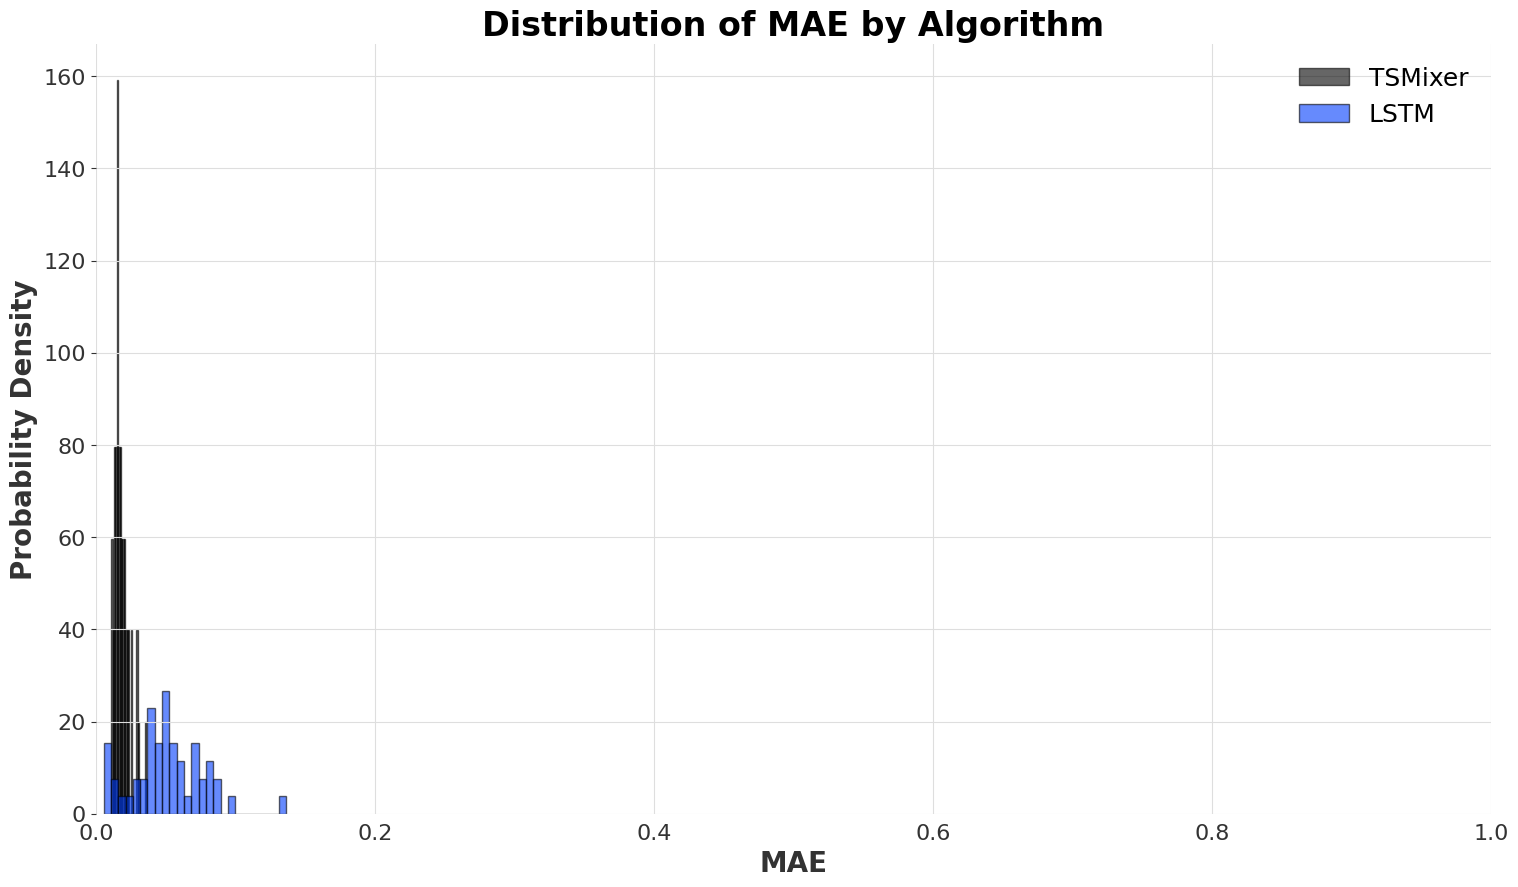

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))  # hình lớn

for algo in combined_metrics["algorithm"].unique():
    subset = combined_metrics[combined_metrics["algorithm"] == algo]
    plt.hist(
        subset["MAE"], 
        bins=25,          
        density=True, 
        alpha=0.6, 
        label=algo,
        edgecolor="black"
    )

plt.xlabel("MAE", fontsize=20)
plt.ylabel("Probability Density", fontsize=20)
plt.title("Distribution of MAE by Algorithm", fontsize=24, weight="bold")
plt.xlim(0, 1)

# chỉnh font cho ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# chỉnh font cho legend
plt.legend(fontsize=18)

# Lưu ảnh cực nét
plt.savefig("/kaggle/working/dl_mae_dist.png", dpi=400, bbox_inches="tight")
plt.show()


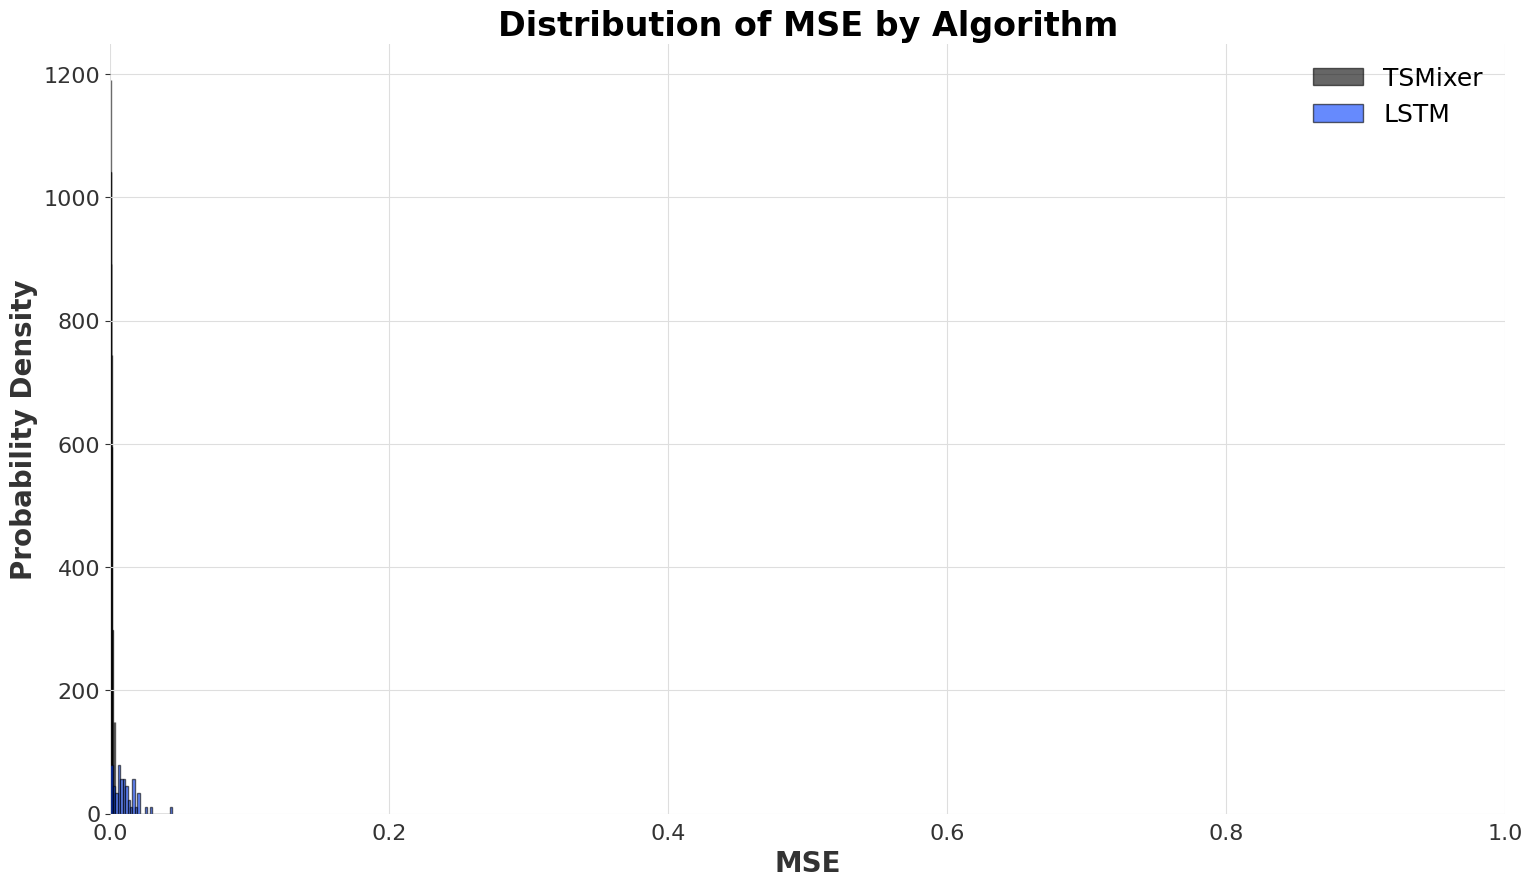

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))  # hình lớn

for algo in combined_metrics["algorithm"].unique():
    subset = combined_metrics[combined_metrics["algorithm"] == algo]
    plt.hist(
        subset["MSE"], 
        bins=25,          
        density=True, 
        alpha=0.6, 
        label=algo,
        edgecolor="black"
    )

plt.xlabel("MSE", fontsize=20)
plt.ylabel("Probability Density", fontsize=20)
plt.title("Distribution of MSE by Algorithm", fontsize=24, weight="bold")
plt.xlim(0, 1)

# chỉnh font cho ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# chỉnh font cho legend
plt.legend(fontsize=18)

# Lưu ảnh cực nét
plt.savefig("/kaggle/working/dl_mse_dist.png", dpi=400, bbox_inches="tight")
plt.show()


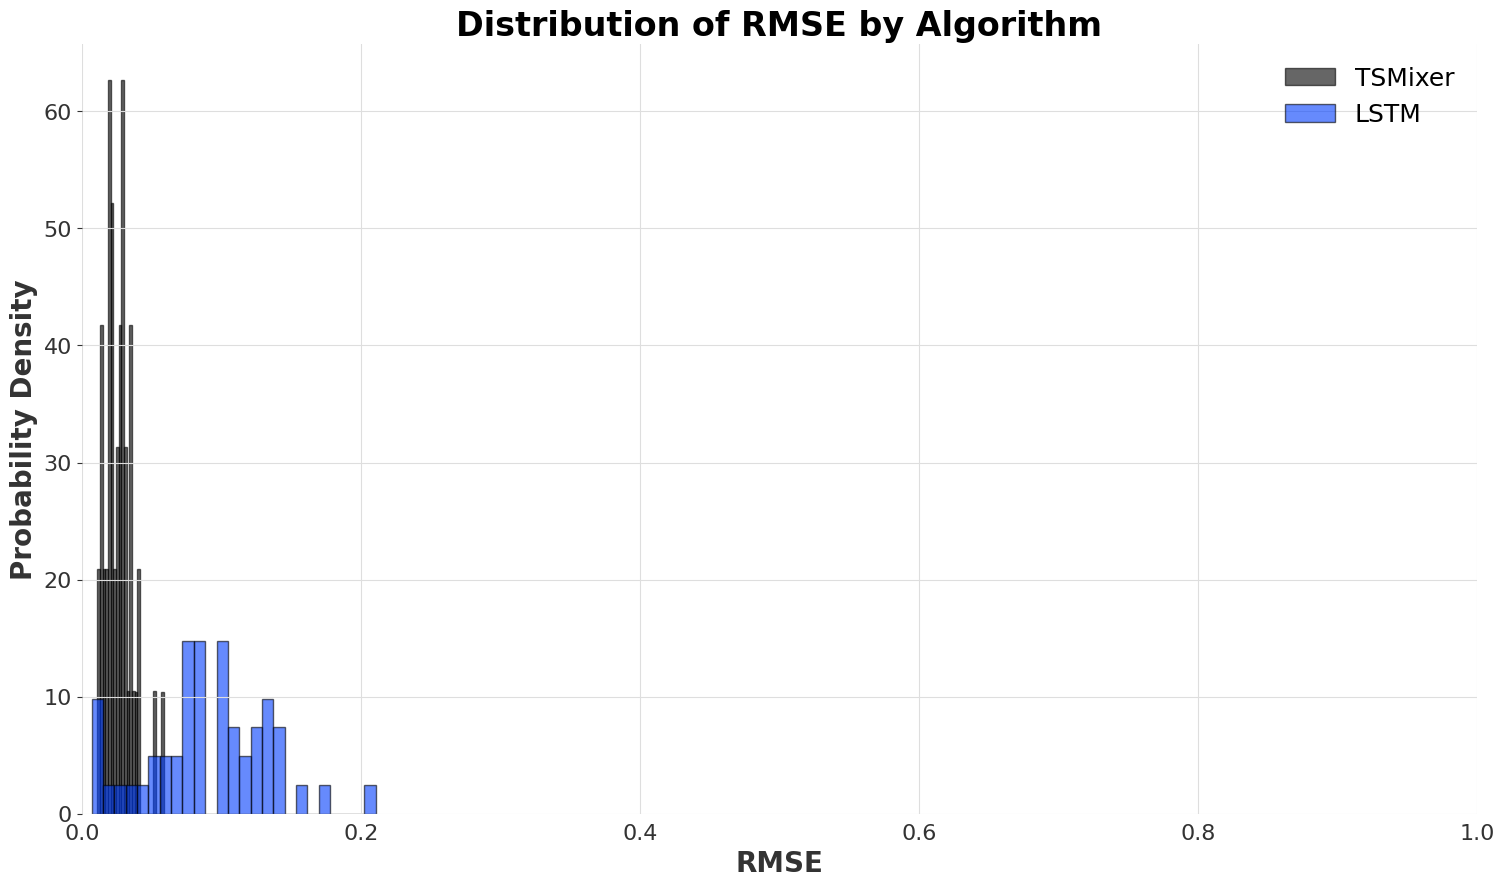

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))  # hình lớn

for algo in combined_metrics["algorithm"].unique():
    subset = combined_metrics[combined_metrics["algorithm"] == algo]
    plt.hist(
        subset["RMSE"], 
        bins=25,          
        density=True, 
        alpha=0.6, 
        label=algo,
        edgecolor="black"
    )

plt.xlabel("RMSE", fontsize=20)
plt.ylabel("Probability Density", fontsize=20)
plt.title("Distribution of RMSE by Algorithm", fontsize=24, weight="bold")
plt.xlim(0, 1)

# chỉnh font cho ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# chỉnh font cho legend
plt.legend(fontsize=18)

# Lưu ảnh cực nét
plt.savefig("/kaggle/working/dl_rmse_dist.png", dpi=400, bbox_inches="tight")
plt.show()


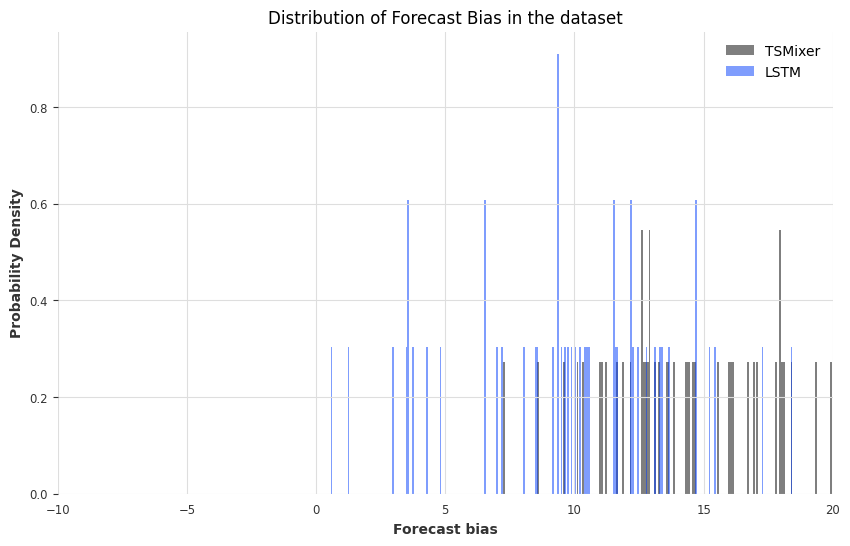

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Vẽ histogram overlay cho từng algorithm
for algo in combined_metrics["algorithm"].unique():
    subset = combined_metrics[combined_metrics["algorithm"] == algo]
    plt.hist(
        subset["Forecast Bias"],
        bins=500,
        density=True,   # giống histnorm="probability density"
        alpha=0.5,
        label=algo
    )

plt.xlabel("Forecast bias")
plt.ylabel("Probability Density")
plt.title("Distribution of Forecast Bias in the dataset")
plt.xlim(-10, 20)
plt.legend()

# Lưu ảnh vào Kaggle working
plt.savefig("/kaggle/working/dl_bias_dist.png", dpi=400, bbox_inches="tight")
plt.show()


In [57]:
display_lclid = "MAC000062"
ts_baseline_test_pred_df = combined_predictions.loc[combined_predictions.household_id==display_lclid]
ts_aggtest_metrics = combined_metrics.loc[combined_metrics.household_id==display_lclid]

In [58]:
lstm_data = ts_baseline_test_pred_df[ts_baseline_test_pred_df['model'] == 'LSTM'].copy()
tsmixer_data = ts_baseline_test_pred_df[ts_baseline_test_pred_df['model'] == 'TSMixer'].copy()

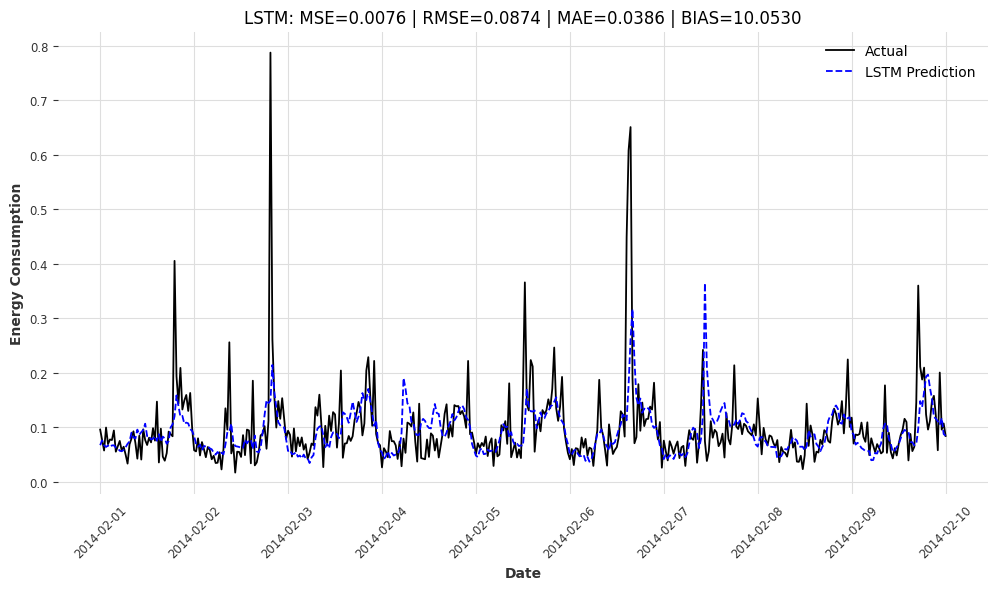

In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử bạn đã có:
# - tsmixer_data: DataFrame chứa cột ["timestamp", "actual", "predicted"]
# - ts_aggtest_metrics: DataFrame chứa metrics (MSE, RMSE, MAE, Forecast Bias) theo từng algorithm

# Lọc khoảng thời gian cần vẽ
mask = (lstm_data["timestamp"] >= "2014-02-01") & (lstm_data["timestamp"] <= "2014-02-10")
plot_data = lstm_data.loc[mask]

# Lấy metrics cho TSMixer
mse  = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="LSTM", "MSE"].iloc[0]
rmse = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="LSTM", "RMSE"].iloc[0]
mae  = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="LSTM", "MAE"].iloc[0]
bias = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="LSTM", "Forecast Bias"].iloc[0]

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.plot(plot_data["timestamp"], plot_data["actual"], label="Actual", color="black")
plt.plot(plot_data["timestamp"], plot_data["predicted"], label="LSTM Prediction", color="blue", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.title(f"LSTM: MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | BIAS={bias:.4f}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("/kaggle/working/lstm_matplotlib.png", dpi=300, bbox_inches="tight")
plt.show()

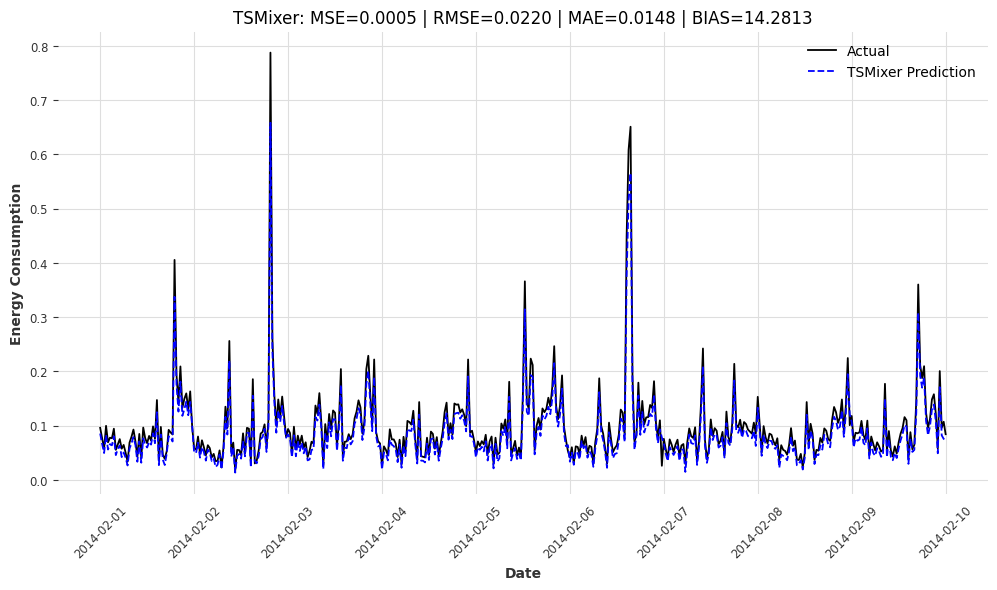

In [60]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử bạn đã có:
# - tsmixer_data: DataFrame chứa cột ["timestamp", "actual", "predicted"]
# - ts_aggtest_metrics: DataFrame chứa metrics (MSE, RMSE, MAE, Forecast Bias) theo từng algorithm

# Lọc khoảng thời gian cần vẽ
mask = (tsmixer_data["timestamp"] >= "2014-02-01") & (tsmixer_data["timestamp"] <= "2014-02-10")
plot_data = tsmixer_data.loc[mask]

# Lấy metrics cho TSMixer
mse  = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="TSMixer", "MSE"].iloc[0]
rmse = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="TSMixer", "RMSE"].iloc[0]
mae  = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="TSMixer", "MAE"].iloc[0]
bias = ts_aggtest_metrics.loc[ts_aggtest_metrics.algorithm=="TSMixer", "Forecast Bias"].iloc[0]

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
plt.plot(plot_data["timestamp"], plot_data["actual"], label="Actual", color="black")
plt.plot(plot_data["timestamp"], plot_data["predicted"], label="TSMixer Prediction", color="blue", linestyle="--")

plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.title(f"TSMixer: MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | BIAS={bias:.4f}")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig("/kaggle/working/tsmixer_matplotlib.png", dpi=300, bbox_inches="tight")
plt.show()
